# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = oversampling_SMOTE(join_c)
print (len(over[0]), len(over[1]), len(over[2])) 

7592 253
3796 1898 1898 126 63 64
7592 3796 1962


### Separando entrada de saida

In [11]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 3796, 1.0: 3796})
Counter({0.0: 1898, 1.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções e constantes auxiliares.

In [13]:
#Taxa de aprendizagem, e usada a mesma em todo o codigo
learnRate = 0.01
graficoName = "SMOTE-0.01-"

In [19]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [16]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.0912 - acc: 0.8937 - val_loss: 0.0892 - val_acc: 0.9004
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0737 - acc: 0.9148 - val_loss: 0.0812 - val_acc: 0.8999
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9148 - val_loss: 0.0816 - val_acc: 0.8967
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0679 - acc: 0.9168 - val_loss: 0.0745 - val_acc: 0.9060
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0671 - acc: 0.9166 - val_loss: 0.0718 - val_acc: 0.9078
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0660 - acc: 0.9174 - val_loss: 0.0707 - val_acc: 0.9075
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0658 - acc: 0.9173 - val_loss: 0.0730 - val_acc: 0.9083
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9183 - val_loss: 0.0701 - val_acc: 0.9049
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9187 - val_loss: 0.0701 - val_acc: 0.9083
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9177 - val_loss: 0.0684 - val_acc: 0.9057
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9189 - val_loss: 0.0687 - val_acc: 0.9083
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9181 - val_loss: 0.0687 - val_acc: 0.9073
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9187 - val_loss: 0.0708 - val_acc: 0.9078
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9177 - val_loss: 0.0694 - val_acc: 0.9075
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9198 - val_loss: 0.0724 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9182 - val_loss: 0.0679 - val_acc: 0.9067
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9182 - val_loss: 0.0718 - val_acc: 0.9067
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0650 - acc: 0.9200 - val_loss: 0.0686 - val_acc: 0.9070
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9190 - val_loss: 0.0701 - val_acc: 0.9070
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9197 - val_loss: 0.0685 - val_acc: 0.9060
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9186 - val_loss: 0.0713 - val_acc: 0.9091
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9185 - val_loss: 0.0698 - val_acc: 0.9075
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9202 - val_loss: 0.0718 -

7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9175 - val_loss: 0.0739 - val_acc: 0.9070
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9189 - val_loss: 0.0692 - val_acc: 0.9078
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9179 - val_loss: 0.0682 - val_acc: 0.9060
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9203 - val_loss: 0.0682 - val_acc: 0.9060
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9186 - val_loss: 0.0710 - val_acc: 0.9062
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9197 - val_loss: 0.0689 - val_acc: 0.9075
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9179 - val_loss: 0.0708 - val_acc: 0.9060
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9190 - val_loss: 0.0682 -

7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9181 - val_loss: 0.0687 - val_acc: 0.9065
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9190 - val_loss: 0.0715 - val_acc: 0.9094
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9186 - val_loss: 0.0695 - val_acc: 0.9070
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9191 - val_loss: 0.0694 - val_acc: 0.9065
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9190 - val_loss: 0.0686 - val_acc: 0.9062
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9191 - val_loss: 0.0693 - val_acc: 0.9044
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9199 - val_loss: 0.0753 - val_acc: 0.9044
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9186 - val_loss: 0.0702 -

7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9195 - val_loss: 0.0690 - val_acc: 0.9062
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9190 - val_loss: 0.0708 - val_acc: 0.9065
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9187 - val_loss: 0.0716 - val_acc: 0.9054
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9179 - val_loss: 0.0689 - val_acc: 0.9078
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9183 - val_loss: 0.0686 - val_acc: 0.9081
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9186 - val_loss: 0.0685 - val_acc: 0.9065
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9189 - val_loss: 0.0728 - val_acc: 0.9028
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9198 - val_loss: 0.0696 -

7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9203 - val_loss: 0.0688 - val_acc: 0.9062
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9190 - val_loss: 0.0684 - val_acc: 0.9062
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9182 - val_loss: 0.0744 - val_acc: 0.9033
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9190 - val_loss: 0.0692 - val_acc: 0.9052
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0651 - acc: 0.9186 - val_loss: 0.0727 - val_acc: 0.9031
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9193 - val_loss: 0.0684 - val_acc: 0.9070
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9181 - val_loss: 0.0680 - val_acc: 0.9078
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9187 - val_loss: 0.0725 -

7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9181 - val_loss: 0.0720 - val_acc: 0.9049
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9197 - val_loss: 0.0696 - val_acc: 0.9070
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9190 - val_loss: 0.0688 - val_acc: 0.9067
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9191 - val_loss: 0.0700 - val_acc: 0.9060
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9181 - val_loss: 0.0712 - val_acc: 0.9046
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9197 - val_loss: 0.0687 - val_acc: 0.9067
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9178 - val_loss: 0.0699 - val_acc: 0.9078
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9182 - val_loss: 0.0683 -

7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9186 - val_loss: 0.0693 - val_acc: 0.9054
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9193 - val_loss: 0.0704 - val_acc: 0.9070
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9191 - val_loss: 0.0703 - val_acc: 0.9067
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9181 - val_loss: 0.0703 - val_acc: 0.9052
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9197 - val_loss: 0.0752 - val_acc: 0.9057
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9191 - val_loss: 0.0695 - val_acc: 0.9073
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9189 - val_loss: 0.0688 - val_acc: 0.9067
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9175 - val_loss: 0.0721 -

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9181 - val_loss: 0.0742 - val_acc: 0.9081
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9187 - val_loss: 0.0692 - val_acc: 0.9065
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9181 - val_loss: 0.0695 - val_acc: 0.9067
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9206 - val_loss: 0.0679 - val_acc: 0.9073
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9183 - val_loss: 0.0757 - val_acc: 0.9054
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9186 - val_loss: 0.0692 - val_acc: 0.9060
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9182 - val_loss: 0.0677 - val_acc: 0.9070
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9186 - val_loss: 0.0699 -

7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9200 - val_loss: 0.0690 - val_acc: 0.9062
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9186 - val_loss: 0.0702 - val_acc: 0.9057
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9179 - val_loss: 0.0705 - val_acc: 0.9033
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9186 - val_loss: 0.0709 - val_acc: 0.9060
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9189 - val_loss: 0.0737 - val_acc: 0.9012
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9181 - val_loss: 0.0706 - val_acc: 0.9052
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9202 - val_loss: 0.0688 - val_acc: 0.9060
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9189 - val_loss: 0.0691 -

7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9185 - val_loss: 0.0682 - val_acc: 0.9065
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9202 - val_loss: 0.0698 - val_acc: 0.9060
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9183 - val_loss: 0.0717 - val_acc: 0.9078
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9191 - val_loss: 0.0692 - val_acc: 0.9062
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9193 - val_loss: 0.0697 - val_acc: 0.9060
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9191 - val_loss: 0.0688 - val_acc: 0.9062
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9185 - val_loss: 0.0691 - val_acc: 0.9057
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9183 - val_loss: 0.0695 -

7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9186 - val_loss: 0.0683 - val_acc: 0.9052
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9181 - val_loss: 0.0714 - val_acc: 0.9070
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9200 - val_loss: 0.0685 - val_acc: 0.9060
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9189 - val_loss: 0.0686 - val_acc: 0.9062
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0724 - val_acc: 0.9060
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9187 - val_loss: 0.0684 - val_acc: 0.9073
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9182 - val_loss: 0.0733 - val_acc: 0.9062
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9170 - val_loss: 0.0682 -

7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9190 - val_loss: 0.0774 - val_acc: 0.9038
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9197 - val_loss: 0.0735 - val_acc: 0.9025
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9197 - val_loss: 0.0687 - val_acc: 0.9057
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9183 - val_loss: 0.0698 - val_acc: 0.9067
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9193 - val_loss: 0.0706 - val_acc: 0.9057
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9190 - val_loss: 0.0684 - val_acc: 0.9065
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9193 - val_loss: 0.0694 - val_acc: 0.9062
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9194 - val_loss: 0.0681 -

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9185 - val_loss: 0.0695 - val_acc: 0.9054
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0685 - val_acc: 0.9062
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9187 - val_loss: 0.0711 - val_acc: 0.9057
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9194 - val_loss: 0.0746 - val_acc: 0.9049
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9175 - val_loss: 0.0689 - val_acc: 0.9070
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9190 - val_loss: 0.0731 - val_acc: 0.9062
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9175 - val_loss: 0.0683 - val_acc: 0.9065
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9187 - val_loss: 0.0689 -

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9185 - val_loss: 0.0687 - val_acc: 0.9054
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9189 - val_loss: 0.0692 - val_acc: 0.9057
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9189 - val_loss: 0.0711 - val_acc: 0.9067
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9181 - val_loss: 0.0696 - val_acc: 0.9046
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9179 - val_loss: 0.0690 - val_acc: 0.9062
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9195 - val_loss: 0.0687 - val_acc: 0.9062
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9186 - val_loss: 0.0742 - val_acc: 0.8994
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9174 - val_loss: 0.0683 -

7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9185 - val_loss: 0.0687 - val_acc: 0.9081
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9186 - val_loss: 0.0696 - val_acc: 0.9067
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9185 - val_loss: 0.0703 - val_acc: 0.9067
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9197 - val_loss: 0.0688 - val_acc: 0.9070
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9178 - val_loss: 0.0695 - val_acc: 0.9062
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0710 - val_acc: 0.9052
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9189 - val_loss: 0.0686 - val_acc: 0.9054
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9195 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9206 - val_loss: 0.0684 - val_acc: 0.9073
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9183 - val_loss: 0.0698 - val_acc: 0.9073
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0648 - acc: 0.9185 - val_loss: 0.0730 - val_acc: 0.9062
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9191 - val_loss: 0.0699 - val_acc: 0.9065
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9190 - val_loss: 0.0684 - val_acc: 0.9062
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9185 - val_loss: 0.0695 - val_acc: 0.9065
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9191 - val_loss: 0.0695 - val_acc: 0.9062
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9202 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0689 - val_acc: 0.9052
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9179 - val_loss: 0.0749 - val_acc: 0.9057
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9186 - val_loss: 0.0698 - val_acc: 0.9073
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9189 - val_loss: 0.0687 - val_acc: 0.9075
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9193 - val_loss: 0.0689 - val_acc: 0.9070
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9179 - val_loss: 0.0708 - val_acc: 0.9044
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9187 - val_loss: 0.0694 - val_acc: 0.9070
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9191 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9197 - val_loss: 0.0702 - val_acc: 0.9060
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9183 - val_loss: 0.0731 - val_acc: 0.9060
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9191 - val_loss: 0.0697 - val_acc: 0.9065
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9191 - val_loss: 0.0691 - val_acc: 0.9078
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9187 - val_loss: 0.0682 - val_acc: 0.9065
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9193 - val_loss: 0.0723 - val_acc: 0.9067
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9195 - val_loss: 0.0694 - val_acc: 0.9075
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9187 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9187 - val_loss: 0.0773 - val_acc: 0.9002
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9174 - val_loss: 0.0682 - val_acc: 0.9083
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9179 - val_loss: 0.0689 - val_acc: 0.9054
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9191 - val_loss: 0.0698 - val_acc: 0.9038
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9190 - val_loss: 0.0694 - val_acc: 0.9065
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9191 - val_loss: 0.0705 - val_acc: 0.9073
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9186 - val_loss: 0.0691 - val_acc: 0.9070
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9178 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9191 - val_loss: 0.0707 - val_acc: 0.9070
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9195 - val_loss: 0.0700 - val_acc: 0.9083
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9178 - val_loss: 0.0696 - val_acc: 0.9046
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9200 - val_loss: 0.0695 - val_acc: 0.9062
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9175 - val_loss: 0.0690 - val_acc: 0.9073
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9194 - val_loss: 0.0710 - val_acc: 0.9067
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9197 - val_loss: 0.0701 - val_acc: 0.9060
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9190 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9183 - val_loss: 0.0727 - val_acc: 0.9070
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9185 - val_loss: 0.0709 - val_acc: 0.9075
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9194 - val_loss: 0.0706 - val_acc: 0.9060
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9194 - val_loss: 0.0683 - val_acc: 0.9067
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9198 - val_loss: 0.0729 - val_acc: 0.9036
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9182 - val_loss: 0.0705 - val_acc: 0.9057
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9182 - val_loss: 0.0714 - val_acc: 0.9057
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9194 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9197 - val_loss: 0.0700 - val_acc: 0.9073
Epoch 1450/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9185 - val_loss: 0.0702 - val_acc: 0.9060
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9194 - val_loss: 0.0694 - val_acc: 0.9057
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9181 - val_loss: 0.0693 - val_acc: 0.9070
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9191 - val_loss: 0.0687 - val_acc: 0.9057
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9206 - val_loss: 0.0712 - val_acc: 0.90330
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0710 - val_acc: 0.9067
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9187 - val_loss: 

7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9191 - val_loss: 0.0685 - val_acc: 0.9054
Epoch 1513/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9179 - val_loss: 0.0695 - val_acc: 0.9062
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9177 - val_loss: 0.0681 - val_acc: 0.9070
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9186 - val_loss: 0.0687 - val_acc: 0.9057
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9186 - val_loss: 0.0704 - val_acc: 0.9065
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9200 - val_loss: 0.0687 - val_acc: 0.9075
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9186 - val_loss: 0.0685 - val_acc: 0.9083
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9179 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9197 - val_loss: 0.0693 - val_acc: 0.9067
Epoch 1576/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9187 - val_loss: 0.0683 - val_acc: 0.9065
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9190 - val_loss: 0.0687 - val_acc: 0.9065
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9187 - val_loss: 0.0698 - val_acc: 0.9054
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9193 - val_loss: 0.0691 - val_acc: 0.9060
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9183 - val_loss: 0.0745 - val_acc: 0.9025
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9195 - val_loss: 0.0709 - val_acc: 0.9078
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9194 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9187 - val_loss: 0.0694 - val_acc: 0.9057
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9187 - val_loss: 0.0695 - val_acc: 0.9075
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9195 - val_loss: 0.0690 - val_acc: 0.9052
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0691 - val_acc: 0.9057
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9185 - val_loss: 0.0689 - val_acc: 0.9070
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9186 - val_loss: 0.0734 - val_acc: 0.9062
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9198 - val_loss: 0.0693 - val_acc: 0.9073
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9187 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9178 - val_loss: 0.0729 - val_acc: 0.9049
Epoch 1702/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9199 - val_loss: 0.0698 - val_acc: 0.9075
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9179 - val_loss: 0.0694 - val_acc: 0.9075
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9181 - val_loss: 0.0696 - val_acc: 0.9065
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9187 - val_loss: 0.0697 - val_acc: 0.9073
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9186 - val_loss: 0.0704 - val_acc: 0.9060
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9186 - val_loss: 0.0710 - val_acc: 0.9075
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9187 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9194 - val_loss: 0.0679 - val_acc: 0.9081
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9181 - val_loss: 0.0690 - val_acc: 0.9073
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9182 - val_loss: 0.0684 - val_acc: 0.9065
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9179 - val_loss: 0.0701 - val_acc: 0.9054
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9193 - val_loss: 0.0701 - val_acc: 0.9046
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9191 - val_loss: 0.0737 - val_acc: 0.9028
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9195 - val_loss: 0.0730 - val_acc: 0.9054
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9187 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9190 - val_loss: 0.0706 - val_acc: 0.9060
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9183 - val_loss: 0.0714 - val_acc: 0.9054
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0707 - val_acc: 0.9081
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9185 - val_loss: 0.0683 - val_acc: 0.9065
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9189 - val_loss: 0.0699 - val_acc: 0.9075
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9187 - val_loss: 0.0699 - val_acc: 0.9070
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9181 - val_loss: 0.0690 - val_acc: 0.9060
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9181 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0647 - acc: 0.9194 - val_loss: 0.0696 - val_acc: 0.9062
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9191 - val_loss: 0.0701 - val_acc: 0.9067
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9198 - val_loss: 0.0701 - val_acc: 0.9057
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9191 - val_loss: 0.0705 - val_acc: 0.9062
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9178 - val_loss: 0.0693 - val_acc: 0.9070
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9178 - val_loss: 0.0698 - val_acc: 0.9067
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0694 - val_acc: 0.9073
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0646 - acc: 0.9183 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9191 - val_loss: 0.0694 - val_acc: 0.9060
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9194 - val_loss: 0.0711 - val_acc: 0.9060
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9190 - val_loss: 0.0712 - val_acc: 0.9078
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9186 - val_loss: 0.0702 - val_acc: 0.9054
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9198 - val_loss: 0.0683 - val_acc: 0.9065
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0645 - acc: 0.9191 - val_loss: 0.0709 - val_acc: 0.9060
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9189 - val_loss: 0.0699 - val_acc: 0.9052
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0642 - acc: 0.9194 - val_loss: 0

In [17]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.052074774720010167, 0.93985728854190076]


<IPython.core.display.Javascript object>


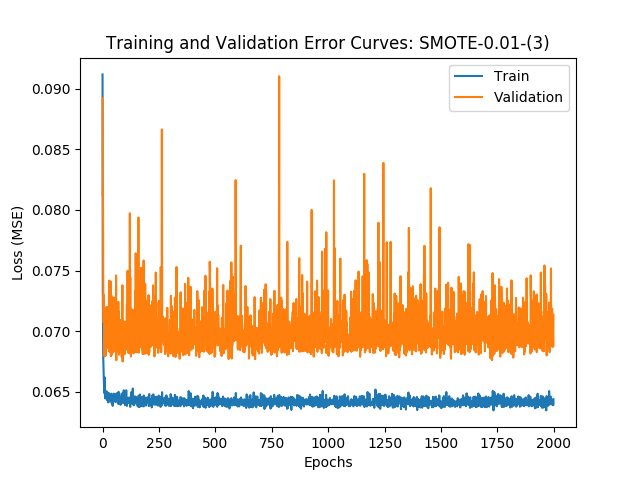

<IPython.core.display.Javascript object>


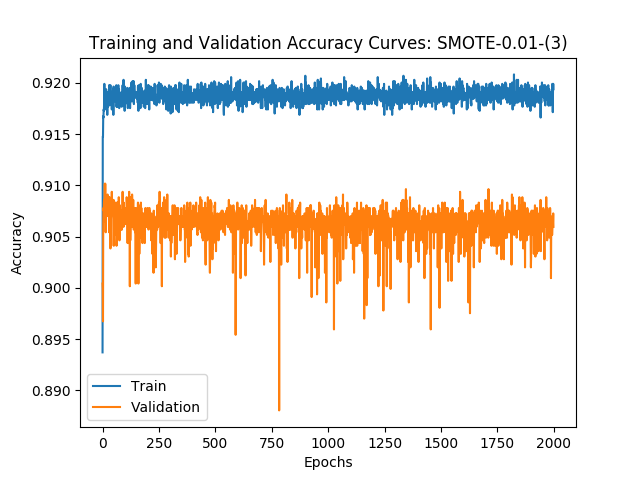

Matriz de confusão
[[1789  109]
 [   9   55]]

Train Loss:       0.0641
Validation Loss:  0.0675
Accuracy:         0.9399
MSE:              0.0601
AUROC:            0.9465


In [20]:
plot_training_error_curves(history, graficoName + "(3)")
plot_training_acc_curves(history, graficoName + "(3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [21]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.1363 - acc: 0.8360 - val_loss: 0.0771 - val_acc: 0.9038
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9194 - val_loss: 0.0754 - val_acc: 0.9139
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0644 - acc: 0.9251 - val_loss: 0.0701 - val_acc: 0.9178
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9260 - val_loss: 0.0767 - val_acc: 0.9112
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9245 - val_loss: 0.0630 - val_acc: 0.9299
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0611 - acc: 0.9301 - val_loss: 0.0714 - val_acc: 0.9189
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0608 - acc: 0.9291 - val_loss: 0.0643 - val_acc: 0.9247
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9312 - val_loss: 0.0718 - val_acc: 0.9312
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9324 - val_loss: 0.0633 - val_acc: 0.9254
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9328 - val_loss: 0.0636 - val_acc: 0.9247
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9334 - val_loss: 0.0700 - val_acc: 0.9189
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9326 - val_loss: 0.0663 - val_acc: 0.9231
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9322 - val_loss: 0.0672 - val_acc: 0.9247
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9328 - val_loss: 0.0666 - val_acc: 0.9204
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9334 - val_loss: 0.0652 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9312 - val_loss: 0.0697 - val_acc: 0.9236
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9327 - val_loss: 0.0660 - val_acc: 0.9220
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9335 - val_loss: 0.0647 - val_acc: 0.9257
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9324 - val_loss: 0.0741 - val_acc: 0.9139
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9322 - val_loss: 0.0642 - val_acc: 0.9265
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9318 - val_loss: 0.0657 - val_acc: 0.9207
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9339 - val_loss: 0.0637 - val_acc: 0.9299
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9305 - val_loss: 0.0712 -

7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9328 - val_loss: 0.0671 - val_acc: 0.9283
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9311 - val_loss: 0.0669 - val_acc: 0.9247
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9326 - val_loss: 0.0646 - val_acc: 0.9249
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9332 - val_loss: 0.0671 - val_acc: 0.9241
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9327 - val_loss: 0.0648 - val_acc: 0.9247
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9334 - val_loss: 0.0635 - val_acc: 0.9302
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9332 - val_loss: 0.0652 - val_acc: 0.9254
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9341 - val_loss: 0.0666 -

7592/7592 [==============================] - 0s - loss: 0.0564 - acc: 0.9332 - val_loss: 0.0653 - val_acc: 0.9291
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9330 - val_loss: 0.0713 - val_acc: 0.9215
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9330 - val_loss: 0.0647 - val_acc: 0.9297
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9327 - val_loss: 0.0681 - val_acc: 0.9247
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9316 - val_loss: 0.0672 - val_acc: 0.9226
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9345 - val_loss: 0.0688 - val_acc: 0.9204
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9312 - val_loss: 0.0682 - val_acc: 0.9276
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9324 - val_loss: 0.0639 -

7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9315 - val_loss: 0.0656 - val_acc: 0.9318
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9306 - val_loss: 0.0689 - val_acc: 0.9268
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9308 - val_loss: 0.0666 - val_acc: 0.9278
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9326 - val_loss: 0.0704 - val_acc: 0.9212
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9319 - val_loss: 0.0672 - val_acc: 0.9247
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9322 - val_loss: 0.0692 - val_acc: 0.9226
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9330 - val_loss: 0.0636 - val_acc: 0.9291
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9315 - val_loss: 0.0662 -

7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9330 - val_loss: 0.0678 - val_acc: 0.9186
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9335 - val_loss: 0.0665 - val_acc: 0.9278
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9319 - val_loss: 0.0645 - val_acc: 0.9276
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9307 - val_loss: 0.0691 - val_acc: 0.9265
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9320 - val_loss: 0.0628 - val_acc: 0.9262
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9322 - val_loss: 0.0636 - val_acc: 0.9252
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9335 - val_loss: 0.0688 - val_acc: 0.9146
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9327 - val_loss: 0.0658 -

7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9340 - val_loss: 0.0640 - val_acc: 0.9273
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9311 - val_loss: 0.0676 - val_acc: 0.9289
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9306 - val_loss: 0.0685 - val_acc: 0.9223
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0564 - acc: 0.9319 - val_loss: 0.0637 - val_acc: 0.9283
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9330 - val_loss: 0.0712 - val_acc: 0.9202
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9316 - val_loss: 0.0668 - val_acc: 0.9233
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9343 - val_loss: 0.0671 - val_acc: 0.9207
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9335 - val_loss: 0.0702 -

7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9323 - val_loss: 0.0667 - val_acc: 0.9220
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9337 - val_loss: 0.0718 - val_acc: 0.9239
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9318 - val_loss: 0.0636 - val_acc: 0.9257
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9328 - val_loss: 0.0768 - val_acc: 0.9178
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9318 - val_loss: 0.0663 - val_acc: 0.9257
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9331 - val_loss: 0.0678 - val_acc: 0.9276
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9330 - val_loss: 0.0672 - val_acc: 0.9244
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9310 - val_loss: 0.0644 -

7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9323 - val_loss: 0.0660 - val_acc: 0.9283
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9306 - val_loss: 0.0678 - val_acc: 0.9228
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0562 - acc: 0.9327 - val_loss: 0.0684 - val_acc: 0.9247
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9312 - val_loss: 0.0646 - val_acc: 0.9276
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9336 - val_loss: 0.0738 - val_acc: 0.9199
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9328 - val_loss: 0.0652 - val_acc: 0.9247
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9328 - val_loss: 0.0671 - val_acc: 0.9194
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9330 - val_loss: 0.0636 -

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9316 - val_loss: 0.0641 - val_acc: 0.9273
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9334 - val_loss: 0.0691 - val_acc: 0.9228
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0583 - acc: 0.9315 - val_loss: 0.0698 - val_acc: 0.9204
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9324 - val_loss: 0.0623 - val_acc: 0.9289
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9314 - val_loss: 0.0686 - val_acc: 0.9270
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0584 - acc: 0.9306 - val_loss: 0.0752 - val_acc: 0.9157
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9324 - val_loss: 0.0643 - val_acc: 0.9320
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9322 - val_loss: 0.0646 -

7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9324 - val_loss: 0.0628 - val_acc: 0.9286
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9312 - val_loss: 0.0771 - val_acc: 0.9218
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9330 - val_loss: 0.0642 - val_acc: 0.9260
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9315 - val_loss: 0.0683 - val_acc: 0.9231
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0560 - acc: 0.9320 - val_loss: 0.0681 - val_acc: 0.9233
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9337 - val_loss: 0.0658 - val_acc: 0.9318
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9330 - val_loss: 0.0687 - val_acc: 0.9233
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9320 - val_loss: 0.0667 -

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9320 - val_loss: 0.0660 - val_acc: 0.9294
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9331 - val_loss: 0.0699 - val_acc: 0.9199
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9327 - val_loss: 0.0649 - val_acc: 0.9244
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9322 - val_loss: 0.0644 - val_acc: 0.9241
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9320 - val_loss: 0.0675 - val_acc: 0.9202
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9336 - val_loss: 0.0694 - val_acc: 0.9220
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9328 - val_loss: 0.0637 - val_acc: 0.9276
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9332 - val_loss: 0.0662 -

7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9335 - val_loss: 0.0721 - val_acc: 0.9152
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9344 - val_loss: 0.0639 - val_acc: 0.9289
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9326 - val_loss: 0.0641 - val_acc: 0.9265
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9320 - val_loss: 0.0677 - val_acc: 0.9241
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9323 - val_loss: 0.0732 - val_acc: 0.9254
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9311 - val_loss: 0.0646 - val_acc: 0.9262
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9326 - val_loss: 0.0639 - val_acc: 0.9270
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9328 - val_loss: 0.0651 -

7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9330 - val_loss: 0.0691 - val_acc: 0.9215
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9324 - val_loss: 0.0740 - val_acc: 0.9175
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9336 - val_loss: 0.0679 - val_acc: 0.9218
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9312 - val_loss: 0.0724 - val_acc: 0.9197
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9322 - val_loss: 0.0661 - val_acc: 0.9281
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0564 - acc: 0.9315 - val_loss: 0.0669 - val_acc: 0.9249
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9327 - val_loss: 0.0642 - val_acc: 0.9247
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0561 - acc: 0.9334 - val_loss: 0.0689 -

7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9332 - val_loss: 0.0635 - val_acc: 0.9228
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9312 - val_loss: 0.0658 - val_acc: 0.9297
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9332 - val_loss: 0.0663 - val_acc: 0.9273
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9332 - val_loss: 0.0653 - val_acc: 0.9260
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9330 - val_loss: 0.0689 - val_acc: 0.9218
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9318 - val_loss: 0.0642 - val_acc: 0.9302
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9332 - val_loss: 0.0682 - val_acc: 0.9212
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9331 - val_loss: 0.0648 -

7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9319 - val_loss: 0.0703 - val_acc: 0.9244
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9328 - val_loss: 0.0688 - val_acc: 0.9228
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9330 - val_loss: 0.0636 - val_acc: 0.9283
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9316 - val_loss: 0.0638 - val_acc: 0.9252
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9341 - val_loss: 0.0645 - val_acc: 0.9289
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9322 - val_loss: 0.0671 - val_acc: 0.9310
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9324 - val_loss: 0.0671 - val_acc: 0.9204
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0560 - acc: 0.9324 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9331 - val_loss: 0.0694 - val_acc: 0.9226
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9319 - val_loss: 0.0647 - val_acc: 0.9278
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9315 - val_loss: 0.0643 - val_acc: 0.9278
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9318 - val_loss: 0.0651 - val_acc: 0.9241
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9330 - val_loss: 0.0624 - val_acc: 0.9268
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9334 - val_loss: 0.0742 - val_acc: 0.9160
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9323 - val_loss: 0.0699 - val_acc: 0.9291
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9332 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9331 - val_loss: 0.0716 - val_acc: 0.9204
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9336 - val_loss: 0.0646 - val_acc: 0.9331
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0563 - acc: 0.9330 - val_loss: 0.0699 - val_acc: 0.9270
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9331 - val_loss: 0.0773 - val_acc: 0.9181
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9326 - val_loss: 0.0693 - val_acc: 0.9186
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0562 - acc: 0.9335 - val_loss: 0.0703 - val_acc: 0.9291
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9315 - val_loss: 0.0679 - val_acc: 0.9239
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0579 - acc: 0.9339 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9327 - val_loss: 0.0662 - val_acc: 0.9268
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9326 - val_loss: 0.0656 - val_acc: 0.9286
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9332 - val_loss: 0.0643 - val_acc: 0.9286
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9312 - val_loss: 0.0692 - val_acc: 0.9244
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9316 - val_loss: 0.0655 - val_acc: 0.9262
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9314 - val_loss: 0.0641 - val_acc: 0.9305
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9344 - val_loss: 0.0698 - val_acc: 0.9210
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9307 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9332 - val_loss: 0.0629 - val_acc: 0.9241
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9320 - val_loss: 0.0752 - val_acc: 0.9202
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0582 - acc: 0.9311 - val_loss: 0.0733 - val_acc: 0.9202
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9331 - val_loss: 0.0665 - val_acc: 0.9281
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9331 - val_loss: 0.0676 - val_acc: 0.9265
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9341 - val_loss: 0.0645 - val_acc: 0.9276
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9327 - val_loss: 0.0642 - val_acc: 0.9226
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9316 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9337 - val_loss: 0.0741 - val_acc: 0.9181
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9331 - val_loss: 0.0701 - val_acc: 0.9228
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9318 - val_loss: 0.0794 - val_acc: 0.9125
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9327 - val_loss: 0.0659 - val_acc: 0.9281
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9328 - val_loss: 0.0715 - val_acc: 0.9189
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9324 - val_loss: 0.0663 - val_acc: 0.9252
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0580 - acc: 0.9307 - val_loss: 0.0673 - val_acc: 0.9305
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0589 - acc: 0.9320 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9320 - val_loss: 0.0678 - val_acc: 0.9239
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0578 - acc: 0.9312 - val_loss: 0.0682 - val_acc: 0.9241
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0563 - acc: 0.9319 - val_loss: 0.0683 - val_acc: 0.9241
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0563 - acc: 0.9322 - val_loss: 0.0642 - val_acc: 0.9278
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0564 - acc: 0.9330 - val_loss: 0.0654 - val_acc: 0.9244
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0564 - acc: 0.9319 - val_loss: 0.0718 - val_acc: 0.9178
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9320 - val_loss: 0.0669 - val_acc: 0.9223
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0560 - acc: 0.9320 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9330 - val_loss: 0.0629 - val_acc: 0.9247
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9327 - val_loss: 0.0657 - val_acc: 0.9228
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9318 - val_loss: 0.0635 - val_acc: 0.9281
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9322 - val_loss: 0.0680 - val_acc: 0.9307
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9328 - val_loss: 0.0717 - val_acc: 0.9191
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9302 - val_loss: 0.0709 - val_acc: 0.9189
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9323 - val_loss: 0.0700 - val_acc: 0.9236
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9318 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9322 - val_loss: 0.0694 - val_acc: 0.9231
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9316 - val_loss: 0.0660 - val_acc: 0.9241
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9343 - val_loss: 0.0633 - val_acc: 0.9265
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9328 - val_loss: 0.0678 - val_acc: 0.9241
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9326 - val_loss: 0.0648 - val_acc: 0.9265
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9337 - val_loss: 0.0664 - val_acc: 0.9194
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9312 - val_loss: 0.0689 - val_acc: 0.9241
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9328 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9335 - val_loss: 0.0698 - val_acc: 0.9194
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0562 - acc: 0.9328 - val_loss: 0.0768 - val_acc: 0.9189
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9330 - val_loss: 0.0668 - val_acc: 0.9299
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9327 - val_loss: 0.0816 - val_acc: 0.9152
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9328 - val_loss: 0.0754 - val_acc: 0.9144
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0577 - acc: 0.9302 - val_loss: 0.0650 - val_acc: 0.9273
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0563 - acc: 0.9316 - val_loss: 0.0657 - val_acc: 0.9260
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9327 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9318 - val_loss: 0.0732 - val_acc: 0.9189
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9320 - val_loss: 0.0720 - val_acc: 0.9265
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9343 - val_loss: 0.0677 - val_acc: 0.9210
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9330 - val_loss: 0.0659 - val_acc: 0.9305
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9320 - val_loss: 0.0693 - val_acc: 0.9252
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9306 - val_loss: 0.0653 - val_acc: 0.9281
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9341 - val_loss: 0.0693 - val_acc: 0.9310
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9314 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9322 - val_loss: 0.0740 - val_acc: 0.9157
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9345 - val_loss: 0.0739 - val_acc: 0.9218
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9324 - val_loss: 0.0653 - val_acc: 0.9257
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9331 - val_loss: 0.0704 - val_acc: 0.9228
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0563 - acc: 0.9319 - val_loss: 0.0699 - val_acc: 0.9270
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9323 - val_loss: 0.0665 - val_acc: 0.9252
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0559 - acc: 0.9319 - val_loss: 0.0667 - val_acc: 0.9278
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0581 - acc: 0.9302 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9323 - val_loss: 0.0681 - val_acc: 0.9186
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9326 - val_loss: 0.0643 - val_acc: 0.9247
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0562 - acc: 0.9323 - val_loss: 0.0678 - val_acc: 0.9249
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9322 - val_loss: 0.0630 - val_acc: 0.9273
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9316 - val_loss: 0.0636 - val_acc: 0.9249
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0570 - acc: 0.9315 - val_loss: 0.0639 - val_acc: 0.9252
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9320 - val_loss: 0.0658 - val_acc: 0.9276
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9323 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9327 - val_loss: 0.0664 - val_acc: 0.9236
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0564 - acc: 0.9320 - val_loss: 0.0651 - val_acc: 0.9276
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0562 - acc: 0.9324 - val_loss: 0.0676 - val_acc: 0.9260
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0575 - acc: 0.9334 - val_loss: 0.0675 - val_acc: 0.9244
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9326 - val_loss: 0.0664 - val_acc: 0.9233
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0574 - acc: 0.9318 - val_loss: 0.0636 - val_acc: 0.9281
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0566 - acc: 0.9297 - val_loss: 0.0668 - val_acc: 0.9336
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9332 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9347 - val_loss: 0.0635 - val_acc: 0.9273
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0563 - acc: 0.9314 - val_loss: 0.0641 - val_acc: 0.9254
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0573 - acc: 0.9320 - val_loss: 0.0648 - val_acc: 0.9291
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0568 - acc: 0.9323 - val_loss: 0.0705 - val_acc: 0.9236
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9339 - val_loss: 0.0670 - val_acc: 0.9239
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0576 - acc: 0.9324 - val_loss: 0.0753 - val_acc: 0.9162
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0565 - acc: 0.9339 - val_loss: 0.0691 - val_acc: 0.9226
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9301 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0562 - acc: 0.9331 - val_loss: 0.0651 - val_acc: 0.9270
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9335 - val_loss: 0.0733 - val_acc: 0.9170
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9341 - val_loss: 0.0654 - val_acc: 0.9268
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9311 - val_loss: 0.0677 - val_acc: 0.9257
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0572 - acc: 0.9345 - val_loss: 0.0633 - val_acc: 0.9273
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0569 - acc: 0.9315 - val_loss: 0.0665 - val_acc: 0.9231
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0567 - acc: 0.9327 - val_loss: 0.0729 - val_acc: 0.9202
Epoch 1961/2000
7592/7592 [==============================] - 0s - loss: 0.0571 - acc: 0.9310 - val_loss: 0

In [22]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.058871673478931949, 0.93221202842078565]


<IPython.core.display.Javascript object>


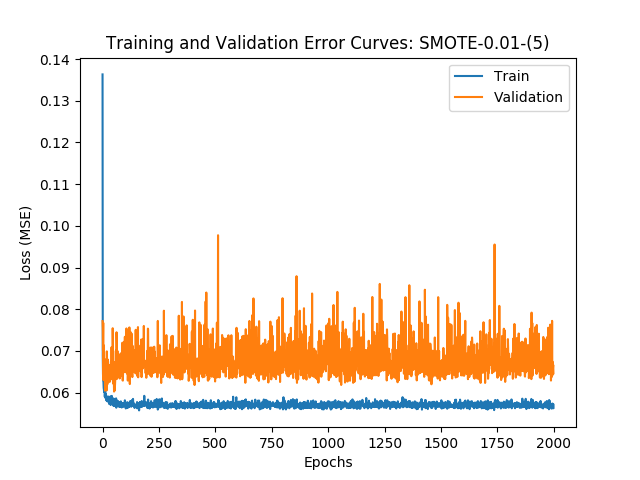

<IPython.core.display.Javascript object>


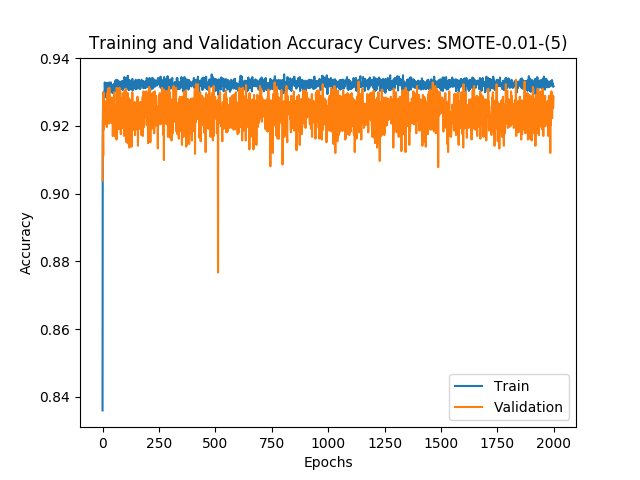

Matriz de confusão
[[1772  126]
 [   7   57]]

Train Loss:       0.0578
Validation Loss:  0.0602
Accuracy:         0.9322
MSE:              0.0678
AUROC:            0.9445


In [23]:
plot_training_error_curves(history, graficoName + "(5)")
plot_training_acc_curves(history, graficoName + "(5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (3, 5)

In [24]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam, 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.1142 - acc: 0.8712 - val_loss: 0.1002 - val_acc: 0.8959
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0798 - acc: 0.9094 - val_loss: 0.0884 - val_acc: 0.9054
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0727 - acc: 0.9179 - val_loss: 0.0893 - val_acc: 0.8967
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0703 - acc: 0.9183 - val_loss: 0.0863 - val_acc: 0.8994
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9200 - val_loss: 0.0835 - val_acc: 0.8965
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9199 - val_loss: 0.0864 - val_acc: 0.8967
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0682 - acc: 0.9211 - val_loss: 0.0871 - val_acc: 0.8981
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9237 - val_loss: 0.0737 - val_acc: 0.9112
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9235 - val_loss: 0.0747 - val_acc: 0.9112
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9233 - val_loss: 0.0756 - val_acc: 0.9110
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9251 - val_loss: 0.0760 - val_acc: 0.9117
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0639 - acc: 0.9231 - val_loss: 0.0749 - val_acc: 0.9099
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9233 - val_loss: 0.0733 - val_acc: 0.9107
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9231 - val_loss: 0.0781 - val_acc: 0.9057
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0641 - acc: 0.9244 - val_loss: 0.0740 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9224 - val_loss: 0.0763 - val_acc: 0.9099
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9249 - val_loss: 0.0752 - val_acc: 0.9136
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0640 - acc: 0.9235 - val_loss: 0.0735 - val_acc: 0.9144
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9241 - val_loss: 0.0748 - val_acc: 0.9133
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9233 - val_loss: 0.0762 - val_acc: 0.9123
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9251 - val_loss: 0.0759 - val_acc: 0.9115
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9229 - val_loss: 0.0749 - val_acc: 0.9110
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9248 - val_loss: 0.0755 -

7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9237 - val_loss: 0.0751 - val_acc: 0.9096
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9243 - val_loss: 0.0736 - val_acc: 0.9083
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9244 - val_loss: 0.0733 - val_acc: 0.9123
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9247 - val_loss: 0.0743 - val_acc: 0.9094
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9248 - val_loss: 0.0758 - val_acc: 0.9086
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9232 - val_loss: 0.0764 - val_acc: 0.9104
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9235 - val_loss: 0.0761 - val_acc: 0.9062
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9227 - val_loss: 0.0734 -

7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9231 - val_loss: 0.0781 - val_acc: 0.9078
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9241 - val_loss: 0.0761 - val_acc: 0.9094
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9240 - val_loss: 0.0743 - val_acc: 0.9112
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9237 - val_loss: 0.0750 - val_acc: 0.9078
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9240 - val_loss: 0.0783 - val_acc: 0.9054
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9236 - val_loss: 0.0780 - val_acc: 0.9046
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9235 - val_loss: 0.0778 - val_acc: 0.9054
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9232 - val_loss: 0.0736 -

7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9237 - val_loss: 0.0749 - val_acc: 0.9070
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9243 - val_loss: 0.0757 - val_acc: 0.9054
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9239 - val_loss: 0.0806 - val_acc: 0.9028
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0638 - acc: 0.9239 - val_loss: 0.0778 - val_acc: 0.9046
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9247 - val_loss: 0.0758 - val_acc: 0.9073
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9231 - val_loss: 0.0759 - val_acc: 0.9083
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9248 - val_loss: 0.0742 - val_acc: 0.9091
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9247 - val_loss: 0.0749 -

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9236 - val_loss: 0.0765 - val_acc: 0.9070
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9229 - val_loss: 0.0770 - val_acc: 0.9070
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9240 - val_loss: 0.0772 - val_acc: 0.9057
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9236 - val_loss: 0.0774 - val_acc: 0.9078
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9251 - val_loss: 0.0761 - val_acc: 0.9057
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9247 - val_loss: 0.0767 - val_acc: 0.9073
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9241 - val_loss: 0.0756 - val_acc: 0.9083
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9245 - val_loss: 0.0760 -

7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9240 - val_loss: 0.0763 - val_acc: 0.9081
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9232 - val_loss: 0.0750 - val_acc: 0.9083
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9236 - val_loss: 0.0761 - val_acc: 0.9070
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9239 - val_loss: 0.0782 - val_acc: 0.9067
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9240 - val_loss: 0.0756 - val_acc: 0.9065
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9236 - val_loss: 0.0769 - val_acc: 0.9057
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9233 - val_loss: 0.0784 - val_acc: 0.9065
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9233 - val_loss: 0.0737 -

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9249 - val_loss: 0.0729 - val_acc: 0.9096
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9248 - val_loss: 0.0747 - val_acc: 0.9091
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9244 - val_loss: 0.0764 - val_acc: 0.9067
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9237 - val_loss: 0.0758 - val_acc: 0.9086
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9240 - val_loss: 0.0773 - val_acc: 0.9052
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9243 - val_loss: 0.0783 - val_acc: 0.9049
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9231 - val_loss: 0.0776 - val_acc: 0.9067
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9243 - val_loss: 0.0778 -

7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9241 - val_loss: 0.0759 - val_acc: 0.9075
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9245 - val_loss: 0.0756 - val_acc: 0.9081
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9241 - val_loss: 0.0767 - val_acc: 0.9094
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9240 - val_loss: 0.0771 - val_acc: 0.9075
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9244 - val_loss: 0.0769 - val_acc: 0.9060
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9237 - val_loss: 0.0768 - val_acc: 0.9078
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9235 - val_loss: 0.0729 - val_acc: 0.9096
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9236 - val_loss: 0.0771 -

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9235 - val_loss: 0.0769 - val_acc: 0.9054
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9243 - val_loss: 0.0771 - val_acc: 0.9065
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9248 - val_loss: 0.0768 - val_acc: 0.9052
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9245 - val_loss: 0.0813 - val_acc: 0.9023
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9231 - val_loss: 0.0771 - val_acc: 0.9057
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9241 - val_loss: 0.0768 - val_acc: 0.9065
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9243 - val_loss: 0.0770 - val_acc: 0.9078
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9244 - val_loss: 0.0760 -

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9237 - val_loss: 0.0782 - val_acc: 0.9081
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9243 - val_loss: 0.0770 - val_acc: 0.9089
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9243 - val_loss: 0.0760 - val_acc: 0.9104
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9249 - val_loss: 0.0797 - val_acc: 0.9062
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9241 - val_loss: 0.0795 - val_acc: 0.9036
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9232 - val_loss: 0.0786 - val_acc: 0.9065
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9243 - val_loss: 0.0761 - val_acc: 0.9062
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9241 - val_loss: 0.0789 -

7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9248 - val_loss: 0.0782 - val_acc: 0.9052
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9247 - val_loss: 0.0759 - val_acc: 0.9062
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9237 - val_loss: 0.0761 - val_acc: 0.9067
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9241 - val_loss: 0.0801 - val_acc: 0.9089
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9243 - val_loss: 0.0766 - val_acc: 0.9052
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9240 - val_loss: 0.0759 - val_acc: 0.9081
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9249 - val_loss: 0.0776 - val_acc: 0.9067
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9244 - val_loss: 0.0787 -

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9239 - val_loss: 0.0797 - val_acc: 0.9054
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9233 - val_loss: 0.0758 - val_acc: 0.9083
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9241 - val_loss: 0.0780 - val_acc: 0.9089
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9231 - val_loss: 0.0827 - val_acc: 0.9062
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9245 - val_loss: 0.0783 - val_acc: 0.9081
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9252 - val_loss: 0.0767 - val_acc: 0.9073
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9241 - val_loss: 0.0769 - val_acc: 0.9086
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9237 - val_loss: 0.0767 -

7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9236 - val_loss: 0.0781 - val_acc: 0.9078
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9241 - val_loss: 0.0764 - val_acc: 0.9057
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9240 - val_loss: 0.0793 - val_acc: 0.9083
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9240 - val_loss: 0.0791 - val_acc: 0.9065
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9244 - val_loss: 0.0787 - val_acc: 0.9065
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9237 - val_loss: 0.0766 - val_acc: 0.9070
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9248 - val_loss: 0.0767 - val_acc: 0.9044
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9240 - val_loss: 0.0775 -

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9241 - val_loss: 0.0769 - val_acc: 0.9060
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9247 - val_loss: 0.0774 - val_acc: 0.9060
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9253 - val_loss: 0.0765 - val_acc: 0.9070
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9245 - val_loss: 0.0782 - val_acc: 0.9044
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9247 - val_loss: 0.0779 - val_acc: 0.9067
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9241 - val_loss: 0.0776 - val_acc: 0.9057
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9240 - val_loss: 0.0763 - val_acc: 0.9057
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9236 - val_loss: 0.0781 -

7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9232 - val_loss: 0.0783 - val_acc: 0.9038
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9237 - val_loss: 0.0794 - val_acc: 0.9070
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9237 - val_loss: 0.0783 - val_acc: 0.9067
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9235 - val_loss: 0.0757 - val_acc: 0.9089
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9239 - val_loss: 0.0788 - val_acc: 0.9070
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9252 - val_loss: 0.0784 - val_acc: 0.9081
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9239 - val_loss: 0.0768 - val_acc: 0.9067
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9240 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9233 - val_loss: 0.0790 - val_acc: 0.9067
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9236 - val_loss: 0.0761 - val_acc: 0.9065
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9244 - val_loss: 0.0767 - val_acc: 0.9054
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9243 - val_loss: 0.0786 - val_acc: 0.9057
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9231 - val_loss: 0.0781 - val_acc: 0.9078
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9240 - val_loss: 0.0767 - val_acc: 0.9067
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9244 - val_loss: 0.0792 - val_acc: 0.9081
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9252 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9245 - val_loss: 0.0776 - val_acc: 0.9052
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9241 - val_loss: 0.0773 - val_acc: 0.9049
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9244 - val_loss: 0.0785 - val_acc: 0.9070
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9251 - val_loss: 0.0776 - val_acc: 0.9054
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9237 - val_loss: 0.0772 - val_acc: 0.9062
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9241 - val_loss: 0.0787 - val_acc: 0.9078
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9247 - val_loss: 0.0778 - val_acc: 0.9060
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9241 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9245 - val_loss: 0.0817 - val_acc: 0.9070
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9243 - val_loss: 0.0767 - val_acc: 0.9073
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9251 - val_loss: 0.0787 - val_acc: 0.9054
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9245 - val_loss: 0.0772 - val_acc: 0.9041
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9243 - val_loss: 0.0768 - val_acc: 0.9062
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9239 - val_loss: 0.0779 - val_acc: 0.9081
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9247 - val_loss: 0.0770 - val_acc: 0.9067
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9235 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9236 - val_loss: 0.0773 - val_acc: 0.9078
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9241 - val_loss: 0.0785 - val_acc: 0.9073
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9247 - val_loss: 0.0762 - val_acc: 0.9067
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9243 - val_loss: 0.0790 - val_acc: 0.9057
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9237 - val_loss: 0.0799 - val_acc: 0.9067
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9231 - val_loss: 0.0766 - val_acc: 0.9073
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9241 - val_loss: 0.0792 - val_acc: 0.9052
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9239 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9232 - val_loss: 0.0801 - val_acc: 0.9070
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9240 - val_loss: 0.0775 - val_acc: 0.9070
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9240 - val_loss: 0.0772 - val_acc: 0.9054
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9227 - val_loss: 0.0774 - val_acc: 0.9062
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9239 - val_loss: 0.0780 - val_acc: 0.9065
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9240 - val_loss: 0.0785 - val_acc: 0.9062
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9247 - val_loss: 0.0773 - val_acc: 0.9075
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9244 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9253 - val_loss: 0.0777 - val_acc: 0.9073
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9241 - val_loss: 0.0791 - val_acc: 0.9044
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9243 - val_loss: 0.0798 - val_acc: 0.9062
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9240 - val_loss: 0.0794 - val_acc: 0.9060
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9239 - val_loss: 0.0779 - val_acc: 0.9073
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9251 - val_loss: 0.0784 - val_acc: 0.9075
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9245 - val_loss: 0.0763 - val_acc: 0.9081
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9237 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0636 - acc: 0.9243 - val_loss: 0.0782 - val_acc: 0.9057
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9247 - val_loss: 0.0777 - val_acc: 0.9060
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9237 - val_loss: 0.0777 - val_acc: 0.9049
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9233 - val_loss: 0.0753 - val_acc: 0.9099
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9240 - val_loss: 0.0774 - val_acc: 0.9075
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9236 - val_loss: 0.0788 - val_acc: 0.9060
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9240 - val_loss: 0.0759 - val_acc: 0.9067
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9241 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9243 - val_loss: 0.0753 - val_acc: 0.9073
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9241 - val_loss: 0.0777 - val_acc: 0.9057
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0624 - acc: 0.9247 - val_loss: 0.0819 - val_acc: 0.9044
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9245 - val_loss: 0.0763 - val_acc: 0.9081
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9248 - val_loss: 0.0767 - val_acc: 0.9062
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9239 - val_loss: 0.0766 - val_acc: 0.9081
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9247 - val_loss: 0.0765 - val_acc: 0.9067
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9245 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9239 - val_loss: 0.0777 - val_acc: 0.9060
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9245 - val_loss: 0.0784 - val_acc: 0.9075
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9239 - val_loss: 0.0773 - val_acc: 0.9067
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9241 - val_loss: 0.0777 - val_acc: 0.9041
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9243 - val_loss: 0.0766 - val_acc: 0.9062
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9245 - val_loss: 0.0861 - val_acc: 0.8999
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9235 - val_loss: 0.0766 - val_acc: 0.9070
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9231 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9244 - val_loss: 0.0775 - val_acc: 0.9102
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9240 - val_loss: 0.0782 - val_acc: 0.9086
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9239 - val_loss: 0.0755 - val_acc: 0.9112
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0635 - acc: 0.9228 - val_loss: 0.0777 - val_acc: 0.9096
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0634 - acc: 0.9239 - val_loss: 0.0772 - val_acc: 0.9099
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9249 - val_loss: 0.0819 - val_acc: 0.9091
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9235 - val_loss: 0.0768 - val_acc: 0.9102
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9243 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9241 - val_loss: 0.0786 - val_acc: 0.9052
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9248 - val_loss: 0.0767 - val_acc: 0.9065
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9233 - val_loss: 0.0790 - val_acc: 0.9078
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0637 - acc: 0.9245 - val_loss: 0.0821 - val_acc: 0.9081
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9247 - val_loss: 0.0778 - val_acc: 0.9049
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9241 - val_loss: 0.0772 - val_acc: 0.9083
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9235 - val_loss: 0.0780 - val_acc: 0.9052
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9247 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9243 - val_loss: 0.0766 - val_acc: 0.9057
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9247 - val_loss: 0.0776 - val_acc: 0.9065
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9235 - val_loss: 0.0771 - val_acc: 0.9065
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9247 - val_loss: 0.0777 - val_acc: 0.9067
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9247 - val_loss: 0.0776 - val_acc: 0.9062
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9247 - val_loss: 0.0773 - val_acc: 0.9067
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9247 - val_loss: 0.0787 - val_acc: 0.9046
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9243 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9249 - val_loss: 0.0819 - val_acc: 0.9038
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0631 - acc: 0.9248 - val_loss: 0.0780 - val_acc: 0.9052
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9253 - val_loss: 0.0770 - val_acc: 0.9054
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9260 - val_loss: 0.0780 - val_acc: 0.9067
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9232 - val_loss: 0.0778 - val_acc: 0.9070
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9245 - val_loss: 0.0774 - val_acc: 0.9078
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9231 - val_loss: 0.0772 - val_acc: 0.9070
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9232 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9236 - val_loss: 0.0777 - val_acc: 0.9062
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9241 - val_loss: 0.0778 - val_acc: 0.9073
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9244 - val_loss: 0.0786 - val_acc: 0.9062
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9243 - val_loss: 0.0762 - val_acc: 0.9057
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9244 - val_loss: 0.0787 - val_acc: 0.9057
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9236 - val_loss: 0.0769 - val_acc: 0.9073
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0627 - acc: 0.9240 - val_loss: 0.0766 - val_acc: 0.9073
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9243 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9247 - val_loss: 0.0765 - val_acc: 0.9067
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0628 - acc: 0.9247 - val_loss: 0.0777 - val_acc: 0.9078
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0629 - acc: 0.9249 - val_loss: 0.0768 - val_acc: 0.9067
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9243 - val_loss: 0.0771 - val_acc: 0.9075
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9239 - val_loss: 0.0768 - val_acc: 0.9065
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0625 - acc: 0.9244 - val_loss: 0.0798 - val_acc: 0.9060
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0626 - acc: 0.9236 - val_loss: 0.0815 - val_acc: 0.9017
Epoch 1961/2000
7592/7592 [==============================] - 0s - loss: 0.0633 - acc: 0.9239 - val_loss: 0

In [25]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1792/1962 [==========================>...] - ETA: 0s[0.045973560739608593, 0.94495412850112603]


<IPython.core.display.Javascript object>


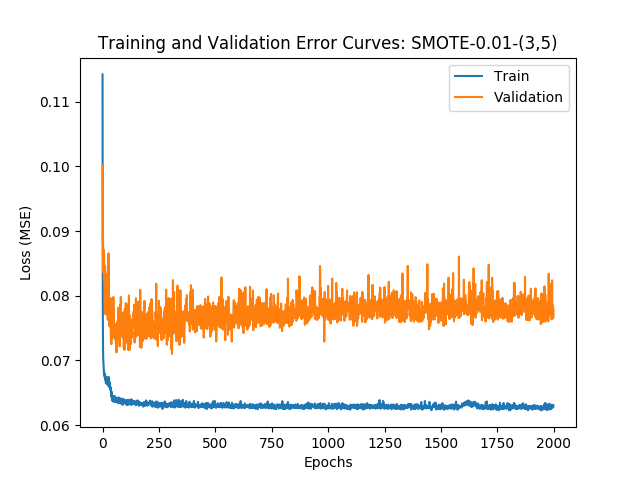

<IPython.core.display.Javascript object>


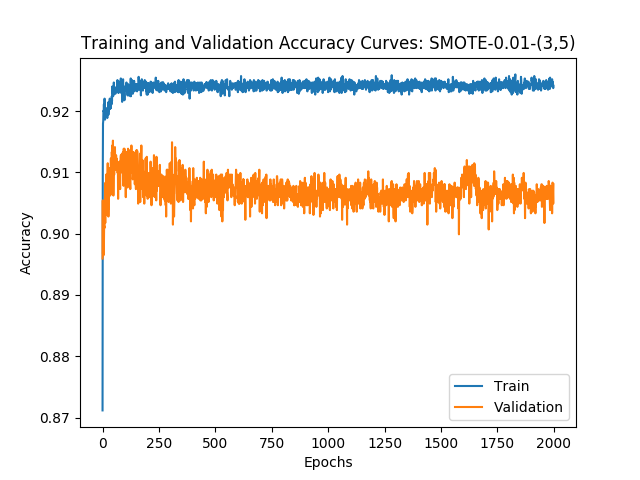

Matriz de confusão
[[1799   99]
 [   9   55]]

Train Loss:       0.0635
Validation Loss:  0.0710
Accuracy:         0.9450
MSE:              0.0550
AUROC:            0.9298


In [26]:
plot_training_error_curves(history, graficoName + "(3,5)")
plot_training_acc_curves(history,graficoName + "(3,5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [27]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.1184 - acc: 0.8554 - val_loss: 0.0916 - val_acc: 0.8857
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0719 - acc: 0.9150 - val_loss: 0.0948 - val_acc: 0.8959
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0671 - acc: 0.9175 - val_loss: 0.0805 - val_acc: 0.9146
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0649 - acc: 0.9229 - val_loss: 0.0826 - val_acc: 0.9038
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0643 - acc: 0.9251 - val_loss: 0.0858 - val_acc: 0.9031
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0632 - acc: 0.9247 - val_loss: 0.0787 - val_acc: 0.9112
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0630 - acc: 0.9262 - val_loss: 0.0786 - val_acc: 0.9128
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9364 - val_loss: 0.0676 - val_acc: 0.9262
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9359 - val_loss: 0.0703 - val_acc: 0.9226
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0540 - acc: 0.9360 - val_loss: 0.0636 - val_acc: 0.9244
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0532 - acc: 0.9355 - val_loss: 0.0661 - val_acc: 0.9262
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0538 - acc: 0.9357 - val_loss: 0.0661 - val_acc: 0.9265
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0539 - acc: 0.9366 - val_loss: 0.0673 - val_acc: 0.9233
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0536 - acc: 0.9361 - val_loss: 0.0662 - val_acc: 0.9331
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0536 - acc: 0.9369 - val_loss: 0.0658 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9365 - val_loss: 0.0708 - val_acc: 0.9197
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9378 - val_loss: 0.0681 - val_acc: 0.9270
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0532 - acc: 0.9369 - val_loss: 0.0680 - val_acc: 0.9215
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9370 - val_loss: 0.0666 - val_acc: 0.9254
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9390 - val_loss: 0.0665 - val_acc: 0.9305
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9378 - val_loss: 0.0725 - val_acc: 0.9273
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0535 - acc: 0.9372 - val_loss: 0.0707 - val_acc: 0.9302
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0534 - acc: 0.9381 - val_loss: 0.0695 -

7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9382 - val_loss: 0.0699 - val_acc: 0.9265
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9378 - val_loss: 0.0710 - val_acc: 0.9270
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9386 - val_loss: 0.0712 - val_acc: 0.9239
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9394 - val_loss: 0.0706 - val_acc: 0.9249
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9388 - val_loss: 0.0683 - val_acc: 0.9204
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9390 - val_loss: 0.0735 - val_acc: 0.9291
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9378 - val_loss: 0.0672 - val_acc: 0.9252
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9397 - val_loss: 0.0654 -

7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9395 - val_loss: 0.0679 - val_acc: 0.9202
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9389 - val_loss: 0.0698 - val_acc: 0.9273
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9369 - val_loss: 0.0719 - val_acc: 0.9239
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0526 - acc: 0.9386 - val_loss: 0.0665 - val_acc: 0.9226
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0522 - acc: 0.9380 - val_loss: 0.0831 - val_acc: 0.9178
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0530 - acc: 0.9382 - val_loss: 0.0683 - val_acc: 0.9239
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9386 - val_loss: 0.0679 - val_acc: 0.9228
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9399 - val_loss: 0.0696 -

7592/7592 [==============================] - 0s - loss: 0.0528 - acc: 0.9374 - val_loss: 0.0668 - val_acc: 0.9233
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0529 - acc: 0.9388 - val_loss: 0.0671 - val_acc: 0.9307
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9389 - val_loss: 0.0686 - val_acc: 0.9223
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9389 - val_loss: 0.0664 - val_acc: 0.9239
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9378 - val_loss: 0.0740 - val_acc: 0.9276
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0525 - acc: 0.9401 - val_loss: 0.0646 - val_acc: 0.9268
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9391 - val_loss: 0.0660 - val_acc: 0.9257
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9391 - val_loss: 0.0700 -

7592/7592 [==============================] - 0s - loss: 0.0527 - acc: 0.9391 - val_loss: 0.0680 - val_acc: 0.9328
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9388 - val_loss: 0.0690 - val_acc: 0.9265
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9386 - val_loss: 0.0669 - val_acc: 0.9276
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9397 - val_loss: 0.0698 - val_acc: 0.9249
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9385 - val_loss: 0.0682 - val_acc: 0.9241
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0521 - acc: 0.9378 - val_loss: 0.0643 - val_acc: 0.9318
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9384 - val_loss: 0.0702 - val_acc: 0.9265
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9378 - val_loss: 0.0662 -

7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9394 - val_loss: 0.0694 - val_acc: 0.9223
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9393 - val_loss: 0.0686 - val_acc: 0.9218
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9403 - val_loss: 0.0674 - val_acc: 0.9281
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9397 - val_loss: 0.0701 - val_acc: 0.9249
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9389 - val_loss: 0.0731 - val_acc: 0.9181
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9381 - val_loss: 0.0671 - val_acc: 0.9233
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0513 - acc: 0.9389 - val_loss: 0.0676 - val_acc: 0.9334
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0524 - acc: 0.9382 - val_loss: 0.0686 -

7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9388 - val_loss: 0.0673 - val_acc: 0.9231
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0516 - acc: 0.9397 - val_loss: 0.0676 - val_acc: 0.9305
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9405 - val_loss: 0.0705 - val_acc: 0.9241
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9406 - val_loss: 0.0672 - val_acc: 0.9254
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9403 - val_loss: 0.0750 - val_acc: 0.9239
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0519 - acc: 0.9399 - val_loss: 0.0688 - val_acc: 0.9297
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0515 - acc: 0.9395 - val_loss: 0.0650 - val_acc: 0.9247
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0509 - acc: 0.9402 - val_loss: 0.0689 -

7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9393 - val_loss: 0.0646 - val_acc: 0.9270
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9393 - val_loss: 0.0676 - val_acc: 0.9236
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9385 - val_loss: 0.0692 - val_acc: 0.9223
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9403 - val_loss: 0.0698 - val_acc: 0.9323
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0520 - acc: 0.9395 - val_loss: 0.0707 - val_acc: 0.9273
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0512 - acc: 0.9390 - val_loss: 0.0714 - val_acc: 0.9260
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0514 - acc: 0.9398 - val_loss: 0.0744 - val_acc: 0.9276
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0517 - acc: 0.9395 - val_loss: 0.0665 -

7592/7592 [==============================] - 0s - loss: 0.0510 - acc: 0.9407 - val_loss: 0.0751 - val_acc: 0.9228
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0507 - acc: 0.9405 - val_loss: 0.0726 - val_acc: 0.9252
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0505 - acc: 0.9399 - val_loss: 0.0693 - val_acc: 0.9270
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9413 - val_loss: 0.0767 - val_acc: 0.9168
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0518 - acc: 0.9401 - val_loss: 0.0722 - val_acc: 0.9215
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0507 - acc: 0.9415 - val_loss: 0.0694 - val_acc: 0.9210
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0503 - acc: 0.9407 - val_loss: 0.0768 - val_acc: 0.9160
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0508 - acc: 0.9419 - val_loss: 0.0692 -

7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9482 - val_loss: 0.0589 - val_acc: 0.9191
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9473 - val_loss: 0.0584 - val_acc: 0.9223
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0467 - acc: 0.9478 - val_loss: 0.0624 - val_acc: 0.9146
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9497 - val_loss: 0.0635 - val_acc: 0.9170
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9473 - val_loss: 0.0593 - val_acc: 0.9178
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0466 - acc: 0.9469 - val_loss: 0.0601 - val_acc: 0.9186
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9477 - val_loss: 0.0600 - val_acc: 0.9204
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9467 - val_loss: 0.0592 -

7592/7592 [==============================] - 0s - loss: 0.0452 - acc: 0.9480 - val_loss: 0.0642 - val_acc: 0.9157
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0465 - acc: 0.9474 - val_loss: 0.0669 - val_acc: 0.9144
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9492 - val_loss: 0.0637 - val_acc: 0.9149
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9489 - val_loss: 0.0606 - val_acc: 0.9204
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9476 - val_loss: 0.0630 - val_acc: 0.9152
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9486 - val_loss: 0.0631 - val_acc: 0.9154
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9482 - val_loss: 0.0603 - val_acc: 0.9175
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0460 - acc: 0.9480 - val_loss: 0.0610 -

7592/7592 [==============================] - 0s - loss: 0.0461 - acc: 0.9480 - val_loss: 0.0611 - val_acc: 0.9226
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0461 - acc: 0.9455 - val_loss: 0.0584 - val_acc: 0.9223
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9468 - val_loss: 0.0590 - val_acc: 0.9231
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9490 - val_loss: 0.0583 - val_acc: 0.9257
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9492 - val_loss: 0.0614 - val_acc: 0.9199
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9477 - val_loss: 0.0624 - val_acc: 0.9165
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9486 - val_loss: 0.0566 - val_acc: 0.9294
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9476 - val_loss: 0.0561 -

7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9484 - val_loss: 0.0644 - val_acc: 0.9154
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9469 - val_loss: 0.0604 - val_acc: 0.9247
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9489 - val_loss: 0.0590 - val_acc: 0.9257
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9469 - val_loss: 0.0566 - val_acc: 0.9302
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9497 - val_loss: 0.0581 - val_acc: 0.9291
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0452 - acc: 0.9490 - val_loss: 0.0575 - val_acc: 0.9220
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9490 - val_loss: 0.0566 - val_acc: 0.9281
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0456 - acc: 0.9481 - val_loss: 0.0592 -

7592/7592 [==============================] - 0s - loss: 0.0463 - acc: 0.9474 - val_loss: 0.0626 - val_acc: 0.9183
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9488 - val_loss: 0.0592 - val_acc: 0.9228
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0454 - acc: 0.9493 - val_loss: 0.0583 - val_acc: 0.9276
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0458 - acc: 0.9468 - val_loss: 0.0561 - val_acc: 0.9289
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9485 - val_loss: 0.0587 - val_acc: 0.9257
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9476 - val_loss: 0.0568 - val_acc: 0.9268
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9490 - val_loss: 0.0646 - val_acc: 0.9173
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0456 - acc: 0.9485 - val_loss: 0.0564 -

7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9467 - val_loss: 0.0573 - val_acc: 0.9236
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9489 - val_loss: 0.0761 - val_acc: 0.9060
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9485 - val_loss: 0.0611 - val_acc: 0.9199
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9486 - val_loss: 0.0590 - val_acc: 0.9223
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9472 - val_loss: 0.0579 - val_acc: 0.9249
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9489 - val_loss: 0.0569 - val_acc: 0.9236
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9478 - val_loss: 0.0623 - val_acc: 0.9183
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9472 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9490 - val_loss: 0.0573 - val_acc: 0.9239
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9480 - val_loss: 0.0580 - val_acc: 0.9249
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9488 - val_loss: 0.0625 - val_acc: 0.9204
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9493 - val_loss: 0.0602 - val_acc: 0.9204
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9481 - val_loss: 0.0572 - val_acc: 0.9252
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9486 - val_loss: 0.0630 - val_acc: 0.9146
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9492 - val_loss: 0.0598 - val_acc: 0.9194
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9472 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9485 - val_loss: 0.0598 - val_acc: 0.9241
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0454 - acc: 0.9493 - val_loss: 0.0566 - val_acc: 0.9273
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9486 - val_loss: 0.0570 - val_acc: 0.9252
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9485 - val_loss: 0.0573 - val_acc: 0.9239
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9484 - val_loss: 0.0579 - val_acc: 0.9236
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9496 - val_loss: 0.0563 - val_acc: 0.9252
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9473 - val_loss: 0.0595 - val_acc: 0.9199
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9482 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9482 - val_loss: 0.0591 - val_acc: 0.9220
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9486 - val_loss: 0.0593 - val_acc: 0.9218
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0461 - acc: 0.9472 - val_loss: 0.0569 - val_acc: 0.9257
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9497 - val_loss: 0.0603 - val_acc: 0.9236
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9489 - val_loss: 0.0580 - val_acc: 0.9247
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9497 - val_loss: 0.0666 - val_acc: 0.9112
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0452 - acc: 0.9499 - val_loss: 0.0591 - val_acc: 0.9218
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9477 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9501 - val_loss: 0.0589 - val_acc: 0.9273
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9498 - val_loss: 0.0704 - val_acc: 0.9175
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9485 - val_loss: 0.0661 - val_acc: 0.9149
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9488 - val_loss: 0.0593 - val_acc: 0.9231
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9499 - val_loss: 0.0634 - val_acc: 0.9149
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9484 - val_loss: 0.0588 - val_acc: 0.9244
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9493 - val_loss: 0.0577 - val_acc: 0.9215
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9507 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0454 - acc: 0.9472 - val_loss: 0.0600 - val_acc: 0.9247
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9486 - val_loss: 0.0597 - val_acc: 0.9191
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9493 - val_loss: 0.0602 - val_acc: 0.9228
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9470 - val_loss: 0.0599 - val_acc: 0.9207
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9494 - val_loss: 0.0754 - val_acc: 0.9015
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9497 - val_loss: 0.0608 - val_acc: 0.9170
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9481 - val_loss: 0.0599 - val_acc: 0.9233
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9478 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0437 - acc: 0.9488 - val_loss: 0.0596 - val_acc: 0.9210
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9498 - val_loss: 0.0617 - val_acc: 0.9178
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0455 - acc: 0.9473 - val_loss: 0.0689 - val_acc: 0.9144
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9497 - val_loss: 0.0566 - val_acc: 0.9270
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0456 - acc: 0.9497 - val_loss: 0.0567 - val_acc: 0.9247
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0436 - acc: 0.9493 - val_loss: 0.0627 - val_acc: 0.9228
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9488 - val_loss: 0.0595 - val_acc: 0.9204
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0454 - acc: 0.9493 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9473 - val_loss: 0.0608 - val_acc: 0.9212
Epoch 1450/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9499 - val_loss: 0.0615 - val_acc: 0.9194
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9490 - val_loss: 0.0581 - val_acc: 0.9239
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9494 - val_loss: 0.0592 - val_acc: 0.9215
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9493 - val_loss: 0.0605 - val_acc: 0.9210
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9490 - val_loss: 0.0596 - val_acc: 0.9247
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9493 - val_loss: 0.0584 - val_acc: 0.9202
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9490 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0453 - acc: 0.9480 - val_loss: 0.0561 - val_acc: 0.9291
Epoch 1513/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9484 - val_loss: 0.0583 - val_acc: 0.9247
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9485 - val_loss: 0.0621 - val_acc: 0.9160
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9493 - val_loss: 0.0576 - val_acc: 0.9231
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9496 - val_loss: 0.0609 - val_acc: 0.9210
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9493 - val_loss: 0.0693 - val_acc: 0.9078
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9492 - val_loss: 0.0580 - val_acc: 0.9254
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9486 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9497 - val_loss: 0.0597 - val_acc: 0.9257
Epoch 1576/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9486 - val_loss: 0.0557 - val_acc: 0.9289
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9480 - val_loss: 0.0599 - val_acc: 0.9241
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9489 - val_loss: 0.0571 - val_acc: 0.9262
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9492 - val_loss: 0.0631 - val_acc: 0.9197
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9489 - val_loss: 0.0606 - val_acc: 0.9170
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0452 - acc: 0.9478 - val_loss: 0.0589 - val_acc: 0.92360.
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9476 - val_loss:

7592/7592 [==============================] - ETA: 0s - loss: 0.0446 - acc: 0.948 - 0s - loss: 0.0445 - acc: 0.9489 - val_loss: 0.0648 - val_acc: 0.9146
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9511 - val_loss: 0.0620 - val_acc: 0.9260
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9505 - val_loss: 0.0589 - val_acc: 0.9223
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9493 - val_loss: 0.0593 - val_acc: 0.9312
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9499 - val_loss: 0.0580 - val_acc: 0.9233
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9484 - val_loss: 0.0584 - val_acc: 0.9223
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9489 - val_loss: 0.0620 - val_acc: 0.9189
Epoch 1645/2000
7592/7592 [==============================] - 0s - lo

7592/7592 [==============================] - 0s - loss: 0.0452 - acc: 0.9493 - val_loss: 0.0599 - val_acc: 0.9202
Epoch 1701/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9494 - val_loss: 0.0637 - val_acc: 0.9160
Epoch 1702/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9488 - val_loss: 0.0610 - val_acc: 0.9254
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9493 - val_loss: 0.0650 - val_acc: 0.9218
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9485 - val_loss: 0.0584 - val_acc: 0.9257
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9497 - val_loss: 0.0604 - val_acc: 0.9199
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9482 - val_loss: 0.0623 - val_acc: 0.9149
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9482 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9493 - val_loss: 0.0591 - val_acc: 0.9186
Epoch 1764/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9503 - val_loss: 0.0628 - val_acc: 0.9204
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0435 - acc: 0.9496 - val_loss: 0.0602 - val_acc: 0.9228
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0451 - acc: 0.9505 - val_loss: 0.0606 - val_acc: 0.9260
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9486 - val_loss: 0.0612 - val_acc: 0.9223
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0438 - acc: 0.9501 - val_loss: 0.0615 - val_acc: 0.9173
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9468 - val_loss: 0.0580 - val_acc: 0.9241
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9482 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9494 - val_loss: 0.0581 - val_acc: 0.9281
Epoch 1827/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9485 - val_loss: 0.0598 - val_acc: 0.9247
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9494 - val_loss: 0.0696 - val_acc: 0.9086
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9488 - val_loss: 0.0588 - val_acc: 0.9244
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9499 - val_loss: 0.0582 - val_acc: 0.9257
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0443 - acc: 0.9486 - val_loss: 0.0605 - val_acc: 0.9212
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9490 - val_loss: 0.0617 - val_acc: 0.9181
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0446 - acc: 0.9488 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9493 - val_loss: 0.0590 - val_acc: 0.9254
Epoch 1890/2000
7592/7592 [==============================] - 0s - loss: 0.0442 - acc: 0.9489 - val_loss: 0.0583 - val_acc: 0.9220
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0437 - acc: 0.9496 - val_loss: 0.0618 - val_acc: 0.9173
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0440 - acc: 0.9502 - val_loss: 0.0595 - val_acc: 0.9189
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0437 - acc: 0.9490 - val_loss: 0.0663 - val_acc: 0.9123
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9501 - val_loss: 0.0596 - val_acc: 0.9241
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9493 - val_loss: 0.0570 - val_acc: 0.9241
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9492 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0445 - acc: 0.9485 - val_loss: 0.0632 - val_acc: 0.9183
Epoch 1953/2000
7592/7592 [==============================] - 0s - loss: 0.0447 - acc: 0.9490 - val_loss: 0.0591 - val_acc: 0.9252
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0441 - acc: 0.9493 - val_loss: 0.0575 - val_acc: 0.9262
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0448 - acc: 0.9477 - val_loss: 0.0611 - val_acc: 0.9236
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0450 - acc: 0.9502 - val_loss: 0.0620 - val_acc: 0.9194
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0449 - acc: 0.9488 - val_loss: 0.0601 - val_acc: 0.9220
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0437 - acc: 0.9502 - val_loss: 0.0584 - val_acc: 0.9244
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0444 - acc: 0.9486 - val_loss: 0

In [28]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1632/1962 [=======================>......] - ETA: 0s[0.038062948627239822, 0.95056065227399666]


<IPython.core.display.Javascript object>


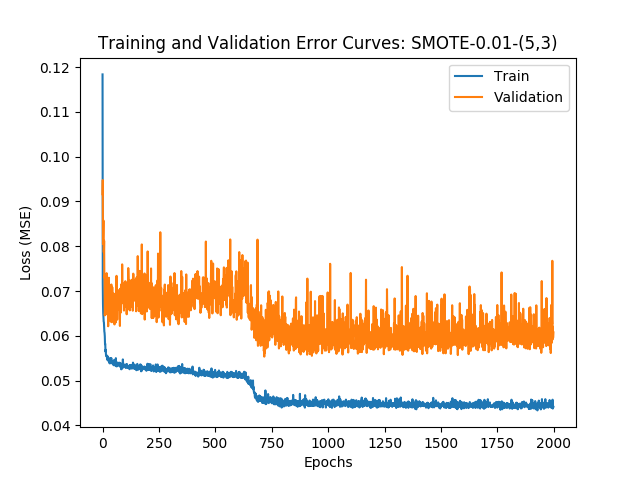

<IPython.core.display.Javascript object>


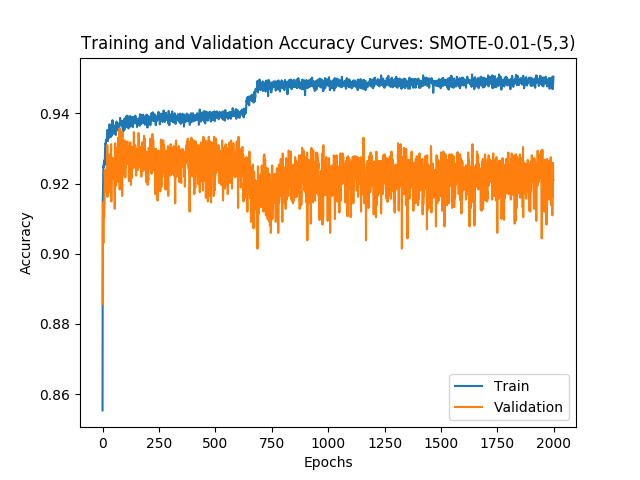

Matriz de confusão
[[1813   85]
 [  11   53]]

Train Loss:       0.0452
Validation Loss:  0.0554
Accuracy:         0.9511
MSE:              0.0489
AUROC:            0.9382


In [29]:
plot_training_error_curves(history, graficoName + "(5,3)")
plot_training_acc_curves(history, graficoName + "(5,3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [30]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.1776 - acc: 0.8301 - val_loss: 0.1240 - val_acc: 0.8841
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.0898 - acc: 0.9063 - val_loss: 0.1185 - val_acc: 0.8867
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.9057 - val_loss: 0.1118 - val_acc: 0.8878
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.0882 - acc: 0.9054 - val_loss: 0.1183 - val_acc: 0.8867
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9038 - val_loss: 0.1121 - val_acc: 0.8909
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9054 - val_loss: 0.1099 - val_acc: 0.8894
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.0879 - acc: 0.9040 - val_loss: 0.1097 - val_acc: 0.8904
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9049 - val_loss: 0.1139 - val_acc: 0.8817
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9053 - val_loss: 0.1183 - val_acc: 0.8822
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9067 - val_loss: 0.1109 - val_acc: 0.8909
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1106 - val_acc: 0.8928
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9053 - val_loss: 0.1115 - val_acc: 0.8804
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9037 - val_loss: 0.1083 - val_acc: 0.8907
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9050 - val_loss: 0.1068 - val_acc: 0.8896
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9031 - val_loss: 0.1090 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9037 - val_loss: 0.1131 - val_acc: 0.8886
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9038 - val_loss: 0.1085 - val_acc: 0.8901
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1175 - val_acc: 0.8801
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9053 - val_loss: 0.1240 - val_acc: 0.8754
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9056 - val_loss: 0.1107 - val_acc: 0.8917
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9053 - val_loss: 0.1118 - val_acc: 0.8878
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9060 - val_loss: 0.1076 - val_acc: 0.8915
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9042 - val_loss: 0.1139 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9048 - val_loss: 0.1172 - val_acc: 0.8828
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9045 - val_loss: 0.1101 - val_acc: 0.8883
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9029 - val_loss: 0.1115 - val_acc: 0.8880
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9053 - val_loss: 0.1075 - val_acc: 0.8930
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9049 - val_loss: 0.1123 - val_acc: 0.8870
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9033 - val_loss: 0.1106 - val_acc: 0.8857
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9036 - val_loss: 0.1216 - val_acc: 0.8793
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9036 - val_loss: 0.1180 -

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9058 - val_loss: 0.1070 - val_acc: 0.8925
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9040 - val_loss: 0.1108 - val_acc: 0.8841
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9063 - val_loss: 0.1220 - val_acc: 0.8783
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0877 - acc: 0.9038 - val_loss: 0.1109 - val_acc: 0.8870
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9065 - val_loss: 0.1197 - val_acc: 0.8820
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1160 - val_acc: 0.8807
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9049 - val_loss: 0.1119 - val_acc: 0.8867
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9033 - val_loss: 0.1123 -

7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9035 - val_loss: 0.1094 - val_acc: 0.8878
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1056 - val_acc: 0.8865
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9066 - val_loss: 0.1055 - val_acc: 0.8899
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9035 - val_loss: 0.1179 - val_acc: 0.8799
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9044 - val_loss: 0.1043 - val_acc: 0.8920
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9049 - val_loss: 0.1149 - val_acc: 0.8872
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9052 - val_loss: 0.1136 - val_acc: 0.8867
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9038 - val_loss: 0.1153 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9031 - val_loss: 0.1102 - val_acc: 0.8899
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9045 - val_loss: 0.1107 - val_acc: 0.8870
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9033 - val_loss: 0.1106 - val_acc: 0.8894
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9042 - val_loss: 0.1115 - val_acc: 0.8888
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9044 - val_loss: 0.1135 - val_acc: 0.8854
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9023 - val_loss: 0.1148 - val_acc: 0.8822
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9040 - val_loss: 0.1049 - val_acc: 0.8925
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9066 - val_loss: 0.1103 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1247 - val_acc: 0.8746
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9028 - val_loss: 0.1206 - val_acc: 0.8772
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9049 - val_loss: 0.1143 - val_acc: 0.8841
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9013 - val_loss: 0.1178 - val_acc: 0.8804
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9049 - val_loss: 0.1150 - val_acc: 0.8830
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9032 - val_loss: 0.1199 - val_acc: 0.8770
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9049 - val_loss: 0.1074 - val_acc: 0.8888
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1148 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9056 - val_loss: 0.1033 - val_acc: 0.8888
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0.1089 - val_acc: 0.8875
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9024 - val_loss: 0.1182 - val_acc: 0.8862
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0877 - acc: 0.9056 - val_loss: 0.1090 - val_acc: 0.8912
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0879 - acc: 0.9042 - val_loss: 0.1087 - val_acc: 0.8915
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9041 - val_loss: 0.1051 - val_acc: 0.8907
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9044 - val_loss: 0.1092 - val_acc: 0.8904
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9032 - val_loss: 0.1091 -

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9060 - val_loss: 0.1131 - val_acc: 0.8867
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9050 - val_loss: 0.1105 - val_acc: 0.8904
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9060 - val_loss: 0.1132 - val_acc: 0.8836
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9052 - val_loss: 0.1123 - val_acc: 0.8862
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9056 - val_loss: 0.1112 - val_acc: 0.8872
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8878
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9029 - val_loss: 0.1075 - val_acc: 0.8904
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9046 - val_loss: 0.1153 -

7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9032 - val_loss: 0.1189 - val_acc: 0.8791
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9057 - val_loss: 0.1062 - val_acc: 0.8915
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1202 - val_acc: 0.8775
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9025 - val_loss: 0.1128 - val_acc: 0.8846
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9057 - val_loss: 0.1206 - val_acc: 0.8751
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9040 - val_loss: 0.1209 - val_acc: 0.8772
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9044 - val_loss: 0.1085 - val_acc: 0.8894
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1072 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9058 - val_loss: 0.1152 - val_acc: 0.8849
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9060 - val_loss: 0.1062 - val_acc: 0.8909
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9049 - val_loss: 0.1136 - val_acc: 0.8812
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9056 - val_loss: 0.1128 - val_acc: 0.8867
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9046 - val_loss: 0.1071 - val_acc: 0.8915
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9045 - val_loss: 0.1078 - val_acc: 0.8917
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9052 - val_loss: 0.1190 - val_acc: 0.8804
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9058 - val_loss: 0.1166 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9040 - val_loss: 0.1047 - val_acc: 0.8917
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1169 - val_acc: 0.8780
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9046 - val_loss: 0.1076 - val_acc: 0.8909
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1109 - val_acc: 0.8904
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9029 - val_loss: 0.1137 - val_acc: 0.8891
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9041 - val_loss: 0.1121 - val_acc: 0.8846
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9041 - val_loss: 0.1136 - val_acc: 0.8891
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9025 - val_loss: 0.1128 -

7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9053 - val_loss: 0.1038 - val_acc: 0.8915
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9037 - val_loss: 0.1127 - val_acc: 0.8841
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9054 - val_loss: 0.1100 - val_acc: 0.8915
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9042 - val_loss: 0.1091 - val_acc: 0.8896
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9027 - val_loss: 0.1114 - val_acc: 0.8904
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9044 - val_loss: 0.1204 - val_acc: 0.8762
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9032 - val_loss: 0.1091 - val_acc: 0.8904
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9056 - val_loss: 0.1171 -

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9038 - val_loss: 0.1128 - val_acc: 0.8830
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9052 - val_loss: 0.1071 - val_acc: 0.8907
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0.1063 - val_acc: 0.8907
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9033 - val_loss: 0.1118 - val_acc: 0.8901
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1133 - val_acc: 0.8928
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9036 - val_loss: 0.1209 - val_acc: 0.8778
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9025 - val_loss: 0.1181 - val_acc: 0.8849
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9053 - val_loss: 0.1136 -

7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9041 - val_loss: 0.1153 - val_acc: 0.8817
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9038 - val_loss: 0.1156 - val_acc: 0.8791
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9050 - val_loss: 0.1092 - val_acc: 0.8920
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9041 - val_loss: 0.1113 - val_acc: 0.8883
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9050 - val_loss: 0.1202 - val_acc: 0.8809
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9045 - val_loss: 0.1084 - val_acc: 0.8936
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9044 - val_loss: 0.1074 - val_acc: 0.8894
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9050 - val_loss: 0.1130 -

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9037 - val_loss: 0.1052 - val_acc: 0.8891
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9044 - val_loss: 0.1279 - val_acc: 0.8704
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1174 - val_acc: 0.8825
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9061 - val_loss: 0.1054 - val_acc: 0.8894
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9052 - val_loss: 0.1206 - val_acc: 0.8830
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1115 - val_acc: 0.8867
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9038 - val_loss: 0.1266 - val_acc: 0.8678
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9054 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9050 - val_loss: 0.1100 - val_acc: 0.8899
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9042 - val_loss: 0.1179 - val_acc: 0.8809
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9045 - val_loss: 0.1104 - val_acc: 0.8909
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1215 - val_acc: 0.8788
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9035 - val_loss: 0.1256 - val_acc: 0.8780
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9036 - val_loss: 0.1164 - val_acc: 0.8828
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9029 - val_loss: 0.1148 - val_acc: 0.8862
Epoch 1079/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9058 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1068 - val_acc: 0.8907
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9048 - val_loss: 0.1097 - val_acc: 0.8870
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9052 - val_loss: 0.1136 - val_acc: 0.8844
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9061 - val_loss: 0.1092 - val_acc: 0.8844
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9053 - val_loss: 0.1229 - val_acc: 0.8791
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0.1130 - val_acc: 0.8875
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9054 - val_loss: 0.1174 - val_acc: 0.8809
Epoch 1142/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9038 - val_loss: 0.1078 - val_acc: 0.8901
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9053 - val_loss: 0.1111 - val_acc: 0.8896
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9037 - val_loss: 0.1203 - val_acc: 0.8746
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9049 - val_loss: 0.1110 - val_acc: 0.8883
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9050 - val_loss: 0.1154 - val_acc: 0.8812
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9037 - val_loss: 0.1126 - val_acc: 0.8907
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9048 - val_loss: 0.1166 - val_acc: 0.8817
Epoch 1205/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9036 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9044 - val_loss: 0.1142 - val_acc: 0.8883
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9063 - val_loss: 0.1157 - val_acc: 0.8844
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9020 - val_loss: 0.1151 - val_acc: 0.8854
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9050 - val_loss: 0.1141 - val_acc: 0.8849
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9045 - val_loss: 0.1193 - val_acc: 0.8762
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9027 - val_loss: 0.1085 - val_acc: 0.8915
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9057 - val_loss: 0.1177 - val_acc: 0.8796
Epoch 1268/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9061 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0865 - acc: 0.9044 - val_loss: 0.1149 - val_acc: 0.8838
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9050 - val_loss: 0.1163 - val_acc: 0.8836
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9053 - val_loss: 0.1094 - val_acc: 0.8928
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9042 - val_loss: 0.1155 - val_acc: 0.8870
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9060 - val_loss: 0.1128 - val_acc: 0.8912
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9029 - val_loss: 0.1107 - val_acc: 0.8936
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9048 - val_loss: 0.1136 - val_acc: 0.8862
Epoch 1331/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9044 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9045 - val_loss: 0.1175 - val_acc: 0.8846
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1048 - val_acc: 0.8917
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9060 - val_loss: 0.1114 - val_acc: 0.8891
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9044 - val_loss: 0.1160 - val_acc: 0.8822
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9036 - val_loss: 0.1165 - val_acc: 0.8825
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9048 - val_loss: 0.1128 - val_acc: 0.8894
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9015 - val_loss: 0.1183 - val_acc: 0.8809
Epoch 1394/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9053 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9046 - val_loss: 0.1142 - val_acc: 0.8822
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9045 - val_loss: 0.1162 - val_acc: 0.8828
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9033 - val_loss: 0.1199 - val_acc: 0.8801
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9042 - val_loss: 0.1130 - val_acc: 0.8899
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1146 - val_acc: 0.8780
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9049 - val_loss: 0.1057 - val_acc: 0.8933
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9045 - val_loss: 0.1102 - val_acc: 0.8917
Epoch 1457/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9063 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9031 - val_loss: 0.1093 - val_acc: 0.8923
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9019 - val_loss: 0.1179 - val_acc: 0.8815
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9058 - val_loss: 0.1090 - val_acc: 0.8862
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9058 - val_loss: 0.1113 - val_acc: 0.8870
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9069 - val_loss: 0.1081 - val_acc: 0.8891
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9044 - val_loss: 0.1176 - val_acc: 0.8854
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9049 - val_loss: 0.1071 - val_acc: 0.8888
Epoch 1520/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9044 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9057 - val_loss: 0.1206 - val_acc: 0.8780
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9041 - val_loss: 0.1079 - val_acc: 0.8917
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9045 - val_loss: 0.1327 - val_acc: 0.8725
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9056 - val_loss: 0.1160 - val_acc: 0.8812
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9032 - val_loss: 0.1098 - val_acc: 0.8904
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1123 - val_acc: 0.8894
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9045 - val_loss: 0.1147 - val_acc: 0.8849
Epoch 1583/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9029 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9062 - val_loss: 0.1183 - val_acc: 0.8825
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9054 - val_loss: 0.1093 - val_acc: 0.8883
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9053 - val_loss: 0.1114 - val_acc: 0.8925
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1096 - val_acc: 0.8899
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9041 - val_loss: 0.1110 - val_acc: 0.8923
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9048 - val_loss: 0.1082 - val_acc: 0.8907
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9040 - val_loss: 0.1118 - val_acc: 0.8838
Epoch 1646/2000
7592/7592 [==============================] - 0s - loss: 0.0865 - acc: 0.9063 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0865 - acc: 0.9060 - val_loss: 0.1218 - val_acc: 0.8757
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9013 - val_loss: 0.1156 - val_acc: 0.8830
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9041 - val_loss: 0.1082 - val_acc: 0.8875
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9058 - val_loss: 0.1145 - val_acc: 0.8851
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9046 - val_loss: 0.1112 - val_acc: 0.8851
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9058 - val_loss: 0.1149 - val_acc: 0.8801
Epoch 1708/2000
7592/7592 [==============================] - 0s - loss: 0.0874 - acc: 0.9037 - val_loss: 0.1110 - val_acc: 0.8849
Epoch 1709/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9042 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9031 - val_loss: 0.1095 - val_acc: 0.8909
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9067 - val_loss: 0.1097 - val_acc: 0.8904
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0864 - acc: 0.9042 - val_loss: 0.1118 - val_acc: 0.8862
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9037 - val_loss: 0.1140 - val_acc: 0.8833
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9048 - val_loss: 0.1095 - val_acc: 0.8854
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0866 - acc: 0.9048 - val_loss: 0.1069 - val_acc: 0.8886
Epoch 1771/2000
7592/7592 [==============================] - 0s - loss: 0.0878 - acc: 0.9035 - val_loss: 0.1109 - val_acc: 0.8888
Epoch 1772/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9032 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9031 - val_loss: 0.1212 - val_acc: 0.8804
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9050 - val_loss: 0.1153 - val_acc: 0.8817
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9058 - val_loss: 0.1137 - val_acc: 0.8841
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9042 - val_loss: 0.1161 - val_acc: 0.8872
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9052 - val_loss: 0.1102 - val_acc: 0.8820
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0872 - acc: 0.9038 - val_loss: 0.1119 - val_acc: 0.8912
Epoch 1834/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9053 - val_loss: 0.1278 - val_acc: 0.8764
Epoch 1835/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9027 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9037 - val_loss: 0.1083 - val_acc: 0.8917
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0876 - acc: 0.9032 - val_loss: 0.1061 - val_acc: 0.8896
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9038 - val_loss: 0.1164 - val_acc: 0.8859
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9042 - val_loss: 0.1103 - val_acc: 0.8896
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9046 - val_loss: 0.1107 - val_acc: 0.8862
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9046 - val_loss: 0.1109 - val_acc: 0.8838
Epoch 1897/2000
7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9058 - val_loss: 0.1189 - val_acc: 0.8809
Epoch 1898/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9031 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0868 - acc: 0.9045 - val_loss: 0.1096 - val_acc: 0.8872
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0870 - acc: 0.9057 - val_loss: 0.1108 - val_acc: 0.8899
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0873 - acc: 0.9031 - val_loss: 0.1105 - val_acc: 0.8912
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0867 - acc: 0.9069 - val_loss: 0.1172 - val_acc: 0.8820
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0875 - acc: 0.9048 - val_loss: 0.1124 - val_acc: 0.8851
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9042 - val_loss: 0.1152 - val_acc: 0.8841
Epoch 1960/2000
7592/7592 [==============================] - 0s - loss: 0.0869 - acc: 0.9037 - val_loss: 0.1102 - val_acc: 0.8878
Epoch 1961/2000
7592/7592 [==============================] - 0s - loss: 0.0871 - acc: 0.9049 - val_loss: 0

In [31]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1962/1962 [==============================] - 0s     
[0.062036256872641568, 0.9327217125989854]


<IPython.core.display.Javascript object>


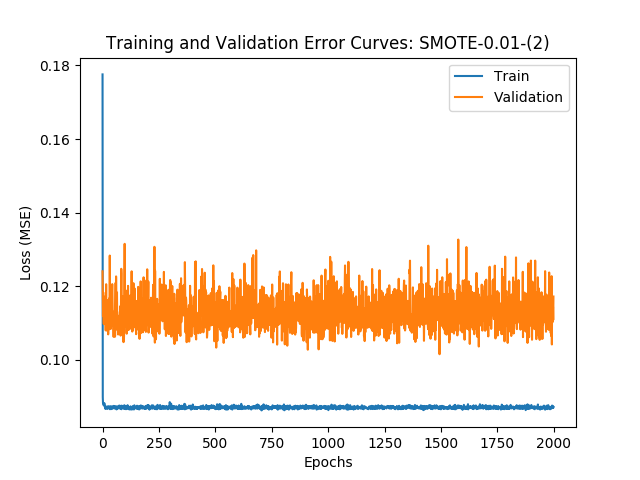

<IPython.core.display.Javascript object>


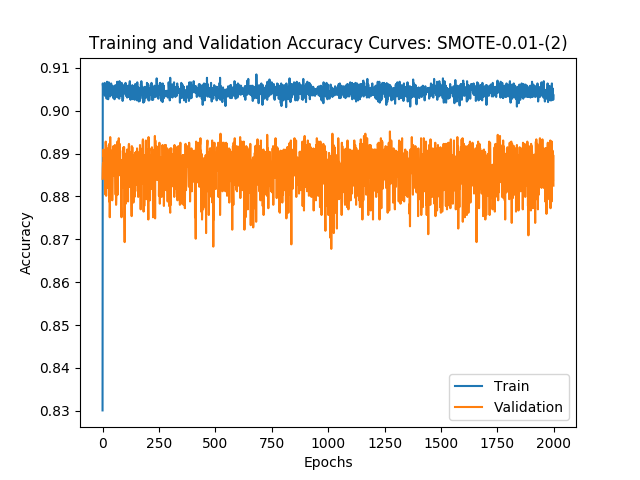

Matriz de confusão
[[1778  120]
 [   9   55]]

Train Loss:       0.0869
Validation Loss:  0.1015
Accuracy:         0.9343
MSE:              0.0657
AUROC:            0.9496


In [32]:
plot_training_error_curves(history, graficoName + "(2)")
plot_training_acc_curves(history, graficoName + "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [ ]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [ ]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

In [ ]:
plot_training_error_curves(history, graficoName + "(4)")
plot_training_acc_curves(history, graficoName + "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))